### Loading necessary library

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from  keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam
import pickle


In [44]:
# Some global variable
imageDimensions = (28,28,3)

### Reading Dataset

In [45]:

path = '/home/hasan/Downloads/MNIST trainingSet'
images = []
classNo = []
myList = os.listdir(path)
print('Total number of classes are :', len(myList))
noOfClasses = len(myList)

for x in range(10):
    myPicList = os.listdir(path+'/'+str(x))
    for y in myPicList:
        try:
            curImg = cv.imread(path+'/'+str(x)+'/'+y)
            #curImag = cv.resize(curImg, (imageDimensions[0],imageDimensions[1]))
            images.append(curImg)
            classNo.append(x)
        except Exception as e:
            pass
    
    print('Class {} has read'.format(x))
    
print('Total number of images are :', len(images))    

Total number of classes are : 10
Class 0 has read
Class 1 has read
Class 2 has read
Class 3 has read
Class 4 has read
Class 5 has read
Class 6 has read
Class 7 has read
Class 8 has read
Class 9 has read
Total number of images are : 42000


### Converting to Array

In [46]:
images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)

(42000, 28, 28, 3)
(42000,)


### Splitting Data

In [47]:
test_ratio = 0.2
validation_ratio = 0.2
Xtrain, xtest, Ytrain,ytest = train_test_split(images, classNo, test_size=test_ratio)
Xtrain, xvalidation, Ytrain, yvalidation = train_test_split(Xtrain, Ytrain, test_size=validation_ratio)
print(Xtrain.shape)
print(xtest.shape)

(26880, 28, 28, 3)
(8400, 28, 28, 3)


### Total number in every class

In [48]:
numOfSamples = []
for x in range(noOfClasses):
    #print(len(np.where(Ytrain==x)[0]))
    numOfSamples.append(len(np.where(Ytrain==x)[0]))
    
print("Total number in every class are :", numOfSamples)

Total number in every class are : [2633, 2966, 2684, 2782, 2588, 2445, 2696, 2797, 2616, 2673]


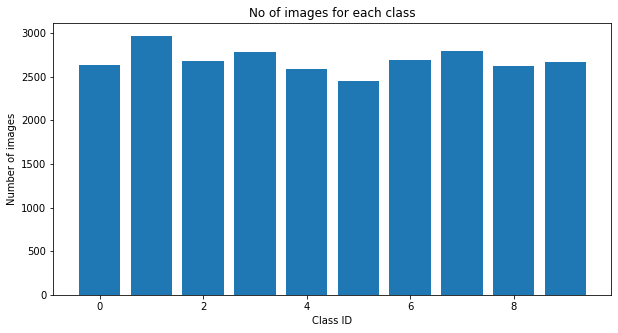

In [49]:
plt.figure(figsize=(10,5))

plt.bar(range(0, noOfClasses), numOfSamples)
plt.title("No of images for each class")
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.show()

### Preprocess Image

In [50]:
def preProcessing(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.equalizeHist(img)
    img = img/255
    return img


Xtrain = np.array(list(map(preProcessing, Xtrain)))
xtest = np.array(list(map(preProcessing, xtest)))
xvalidation = np.array(list(map(preProcessing, xvalidation)))


In [51]:
xvalidation.shape

(6720, 28, 28)

### Reshaping Images Again

In [52]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2],1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], xtest.shape[2],1)
xvalidation = xvalidation.reshape(xvalidation.shape[0], xvalidation.shape[1], xvalidation.shape[2],1)

print(Xtrain.shape)
print(xtest.shape)
print(xvalidation.shape)

(26880, 28, 28, 1)
(8400, 28, 28, 1)
(6720, 28, 28, 1)


### Data Generator

In [53]:
data_gen = ImageDataGenerator(width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.2,
                              shear_range=0.1,
                              rotation_range=10)

data_gen.fit(Xtrain)

### Data Categorical

In [54]:
Ytrain = to_categorical(Ytrain, noOfClasses)
ytest = to_categorical(ytest, noOfClasses)
yvalidation = to_categorical(yvalidation, noOfClasses)


In [55]:
yvalidation.shape

(6720, 10)

### Neural Model

In [56]:
def my_model():
    noOfFilter = 60
    sizeOfFilter = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNode = 500
    
    model = Sequential()
    model.add((Conv2D(noOfFilter, sizeOfFilter, input_shape=(imageDimensions[0],
                                                             imageDimensions[1],
                                                             1), activation='relu')))
    
    model.add((Conv2D(noOfFilter, sizeOfFilter, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilter//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilter//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    
    model.compile(Adam(lr=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model
   

In [57]:
model = my_model()
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 24, 24, 60)        1560      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 60)        90060     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 60)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 30)          16230     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 30)          8130      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 30)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 30)         

In [58]:
# training the model
model_history = model.fit_generator(data_gen.flow(Xtrain, Ytrain,
                                  batch_size=50),
                                  steps_per_epoch=2000,
                                  epochs=10,
                                  validation_data=(xvalidation, yvalidation),
                                  shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 548s 274ms/step - loss: 0.4131 - accuracy: 0.8660 - val_loss: 0.0875 - val_accuracy: 0.9754
Epoch 2/10
2000/2000 [==============================] - 541s 270ms/step - loss: 0.1445 - accuracy: 0.9565 - val_loss: 0.0536 - val_accuracy: 0.9821
Epoch 3/10
2000/2000 [==============================] - 559s 279ms/step - loss: 0.1100 - accuracy: 0.9669 - val_loss: 0.0376 - val_accuracy: 0.9890
Epoch 4/10
2000/2000 [==============================] - 549s 275ms/step - loss: 0.0920 - accuracy: 0.9730 - val_loss: 0.0421 - val_accuracy: 0.9876
Epoch 5/10
2000/2000 [==============================] - 522s 261ms/step - loss: 0.0844 - accuracy: 0.9756 - val_loss: 0.0398 - val_accuracy: 0.9893
Epoch 6/10
2000/2000 [==============================] - 483s 242ms/step - loss: 0.0751 - accuracy: 0.9780 - val_loss: 0.0327 - val_accuracy: 0.9915
Epoch 7/10
2000/2000 [==============================] - 476s 238ms/step - loss: 0.0662 - accuracy: 0.9805 - val_

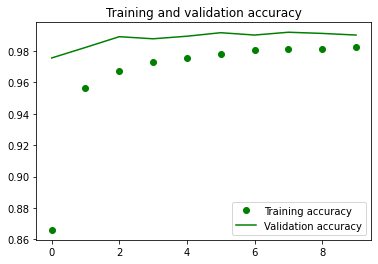

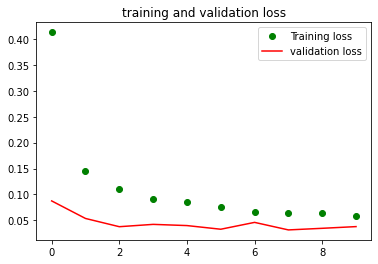

In [60]:
# Accuracy and Loss in graph
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

### Evaluate Model

In [61]:
score = model.evaluate(xtest, ytest, verbose=0)
print('Test score = ', score[0])
print('Test Accuracy = ', score[1])


Test score =  0.045695306319317924
Test Accuracy =  0.9879761934280396


### Save model

In [62]:
pickle_out = open("digit_classification_model.p", 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()
